In [2]:
import torch
import torchvision.transforms as transforms 
import torch.nn.init
from torchsummary import summary as summary_
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets

In [48]:
#Train data 받아오기

path_dir = 'LJH/data/product_data/train/Item-Parse_f' #Parse 폴더에서 파일명 불러오기
file_list_train = os.listdir(path_dir)
file_list_train

['1029391_B.json',
 '1112498_B.json',
 '1028177_B.json',
 '1020155_F.json',
 '1211013_F.json',
 '1202318_B.json',
 '1106198_B.json',
 '1013308_F.json',
 '1203208_B.json',
 '1117018_B.json',
 '1102028_F.json',
 '1126265_F.json',
 '1116527_B.json',
 '1015504_F.json',
 '1210536_B.json',
 '1106310_B.json',
 '1110001_F.json',
 '1112457_F.json',
 '1113098_B.json',
 '1117398_F.json',
 '1118168_B.json',
 '1207459_B.json',
 '1202394_B.json',
 '1207226_B.json',
 '1210501_B.json',
 '1110257_F.json',
 '1105665_F.json',
 '1111228_B.json',
 '1201441_F.json',
 '1016098_B.json',
 '1209278_F.json',
 '1126164_B.json',
 '1021215_F.json',
 '1124325_B.json',
 '1127276_B.json',
 '1023287_F.json',
 '1111019_B.json',
 '1201414_F.json',
 '1109545_B.json',
 '1022058_B.json',
 '1027403_B.json',
 '1211241_B.json',
 '1030308_B.json',
 '1028308_F.json',
 '1120072_B.json',
 '1210797_F.json',
 '1013179_B.json',
 '1015155_B.json',
 '1027136_B.json',
 '1029395_B.json',
 '1117139_F.json',
 '1126300_B.json',
 '1118078_F.

In [49]:
#TRAIN_SIZE = 33170
TRAIN_SIZE = 10000

#label = [0 for i in range(len(file_list_train))] #list형
label = [0 for i in range(10000)] #list형
path_dir_img = 'LJH/data/product_data/train/Item-Image'

def make_file_list():
    #train_img_list = [0 for i in range(len(file_list_train))]
    train_img_list = [0 for i in range(10000)]
    cnt = 0
    #for i in file_list_train:
    for i in range(10000):
    
        with open(path_dir +'/'+ file_list_train[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_train[cnt].split('.')[0]
        train_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label[cnt] = category

        cnt+=1

    return train_img_list


In [50]:
class ImageTransform():

    def __init__(self):
        
        self.data_transform = transforms.Compose([
            transforms.CenterCrop(720),
            transforms.Resize(256),
            transforms.ToTensor(),
        ])
        

    def __call__(self, img):
        return self.data_transform(img)

In [51]:
class Img_Dataset(data.Dataset):

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        img_label = label[index]

        return img_transformed,img_label

In [52]:
train_img_list=make_file_list()

In [53]:
train_dataset = Img_Dataset(file_list=train_img_list,
                            transform=ImageTransform())

In [54]:
train_dataloader = data.DataLoader(train_dataset,
                                   batch_size=128,
                                   shuffle=True,
                                   drop_last=True)
print('Dataloader created')

Dataloader created


In [55]:
batch_iterator = iter(train_dataloader)
images = next(batch_iterator)

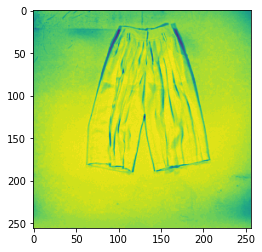

In [56]:
plt.imshow(images[0][3][0])
plt.show() 

In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [58]:
class Alexnet(torch.nn.Module): 
    def __init__(self): 
        super(Alexnet, self).__init__() 
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 5),
        )
        
#    def init_bias(self):
#        for layer in self.net:
#            if isinstance(layer, nn.Conv2d):
#                nn.init.normal_(layer.weight, mean=0, std=0.01)
#                nn.init.constant_(layer.bias, 0)
#        
#        nn.init.constant_(self.net[4].bias, 1)
#        nn.init.constant_(self.net[10].bias, 1)
#        nn.init.constant_(self.net[12].bias, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        

In [59]:
from torchsummary import summary as summary_
DEVICE_IDS = [0,1]
model = Alexnet().to(device)
summary_(model,(3,256,256),batch_size = 128)
Alexnet = torch.nn.parallel.DataParallel(Alexnet, device_ids=DEVICE_IDS)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 64, 63, 63]          23,296
              ReLU-2          [128, 64, 63, 63]               0
         MaxPool2d-3          [128, 64, 31, 31]               0
            Conv2d-4         [128, 192, 31, 31]         307,392
              ReLU-5         [128, 192, 31, 31]               0
         MaxPool2d-6         [128, 192, 15, 15]               0
            Conv2d-7         [128, 384, 15, 15]         663,936
              ReLU-8         [128, 384, 15, 15]               0
            Conv2d-9         [128, 256, 15, 15]         884,992
             ReLU-10         [128, 256, 15, 15]               0
           Conv2d-11         [128, 256, 15, 15]         590,080
             ReLU-12         [128, 256, 15, 15]               0
        MaxPool2d-13           [128, 256, 7, 7]               0
AdaptiveAvgPool2d-14           [128, 25

In [60]:
criterion = torch.nn.CrossEntropyLoss().to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [61]:
total_batch = len(train_dataloader)
for epoch in range(10): 
    avg_cost = 0 
    cnt = 0
    
    for X, Y in train_dataloader: 
        X = X.to(device) 
        Y = Y.to(device) 
        
        optimizer.zero_grad() 
        hypothesis = model(X) 
        cost = criterion(hypothesis, Y) 
        cost.backward() 
        optimizer.step() 
       
        avg_cost += cost / total_batch
        if cnt% 100 == 0:
            print(cnt)
        cnt+=1
           
    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

0
[Epoch:    1] cost = 1.18917024
0
[Epoch:    2] cost = 0.995302618
0
[Epoch:    3] cost = 0.882128477
0
[Epoch:    4] cost = 0.784646571
0
[Epoch:    5] cost = 0.671039522
0
[Epoch:    6] cost = 0.699570119
0
[Epoch:    7] cost = 0.593264818
0
[Epoch:    8] cost = 0.528399467
0
[Epoch:    9] cost = 0.489226639
0
[Epoch:   10] cost = 0.46717608


In [62]:
path_dir = 'LJH/data/product_data/test/Item-Parse_f'
path_dir_img = 'LJH/data/product_data/test/Item-Image'
file_list_test = os.listdir(path_dir)
#label_test = [0 for i in range(len(file_list_test))] #list형
label_test = [0 for i in range(500)] 
def make_file_list_test():
    #test_img_list = [0 for i in range(len(file_list_test))]
    test_img_list = [0 for i in range(500)]
    cnt = 0
    #for i in file_list_test:
    for i in range(500):
    
        with open(path_dir +'/'+ file_list_test[cnt], "r") as st_json:
            load_data = json.load(st_json)

        category = load_data.get('category_id') #class 찾아오기
        #print(category)
        str = file_list_test[cnt].split('.')[0]
        test_img_list[cnt] = path_dir_img +'/'+ str+".jpg" #이미지파일 파일명 생성
        label_test[cnt] = category

        cnt+=1

    return test_img_list

In [63]:
test_img_list=make_file_list_test()

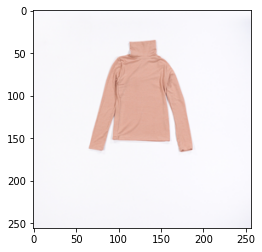

In [64]:
from torchvision.transforms import ToTensor
X_test = torch.empty(0,3,256,256)


image_w = 256 
image_h = 256
cnt_img = 0
for j in test_img_list:
    image = Image.open(test_img_list[cnt_img])
    image = image.crop((0,280,720,1000))
    image = image.resize((256, 256))
    if cnt_img == 0:
        plt.imshow(image)
        plt.show() 
    data = ToTensor()(image).unsqueeze(0)
    X_test =torch.cat([X_test,data],dim=0)
    cnt_img += 1
    if cnt_img % 1000 == 0:
        print(cnt_img)

In [65]:
print(X_test.shape)

torch.Size([500, 3, 256, 256])


In [66]:
Y_test = torch.tensor(label_test)

In [67]:
with torch.no_grad(): 
    X_test = X_test.to(device)
    Y_test = Y_test.to(device)
    prediction = model(X_test) 
    print(prediction.size()) 
    correct_prediction = torch.argmax(prediction, 1) == Y_test 
    accuracy = correct_prediction.float().mean() 
    print('Accuracy: ', accuracy.item())

torch.Size([500, 5])
Accuracy:  0.8700000643730164


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu
